# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from fancy_einsum import einsum
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from torch.autograd import Variable


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# the model
class MNIST_CNN(nn.Module):  
    
    def __init__(self, p=0.2):
        super(MNIST_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 2)
        self.drop = nn.Dropout(p=p)

    def forward(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

    def get_neurons(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        return X
    
    def get_neurons_pre(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        X = self.fc1(X)
        return X

    def get_features(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        X = X.view(-1, 400)
        return X

    def get_conv1(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        return X

    def get_conv2(self, X):
        X = self.pool(self.drop(F.relu(self.conv1(X))))
        X = self.pool(self.drop(F.relu(self.conv2(X))))
        return X

In [4]:
# function to get the model's labels
def get_labels(model, data_loader, device):
    model.eval() 
    labels = []
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_hat = model(X)
            _, pred_labels = torch.max(y_hat.data, 1)
            labels.extend(torch.squeeze(pred_labels).tolist())
    return labels

In [5]:
# get data
transform_mnist = transforms.Compose([transforms.ToTensor()])
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
mnist_train_loader = torch.utils.data.DataLoader(trainset_mnist, batch_size=64, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(testset_mnist, batch_size=64, shuffle=False)

Hint 1: The labels are binary.

Hint 2: The model gets 95.58% accuracy on the test set.

Hint 3: The labeling function can be described in words in one sentence. 

Hint 4: This image might be helpful.

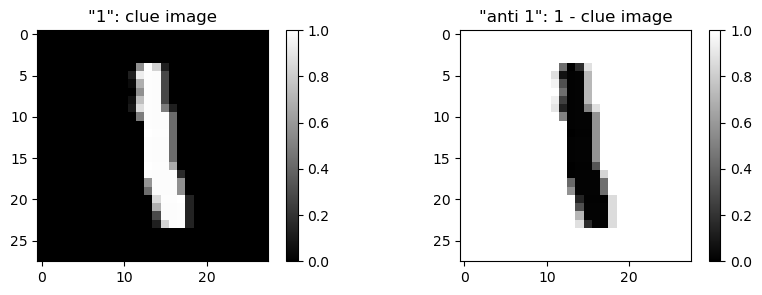

In [6]:
clue_image = trainset_mnist[6][0]
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
cbar = ax[0].imshow(clue_image[0].numpy(), cmap='gist_gray')
ax[0].set_title('"1": clue image')
# Add colorbar
fig.colorbar(cbar, ax=ax[0])
ax[1].imshow(1-clue_image[0].numpy(), cmap='gist_gray')
ax[1].set_title('"anti 1": 1 - clue image')
fig.colorbar(cbar, ax=ax[1])
plt.show()

In [7]:
mnist_model = MNIST_CNN().to(DEVICE)
mnist_model.load_state_dict(torch.load('mnist_model.pt', DEVICE))
#model_labels = get_labels(model=mnist_model, data_loader=mnist_test_loader, device=DEVICE)
mnist_model.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

# Compute outputs and activations

In [8]:
all_inputs_flat = torch.zeros((60_000, 28*28))
all_labels_10 = torch.zeros((60_000, ))
all_acts_L2 = torch.zeros((60_000, 200))
all_acts_features = torch.zeros((60_000, 400))
all_labels_challenge = torch.zeros((60_000, ))
all_conv1 = torch.zeros((60_000, 8, 13, 13))
all_conv2 = torch.zeros((60_000, 16, 5, 5))
all_logits = torch.zeros((60_000, 2))

idx = 0
for x, y in mnist_train_loader:

    bs = x.shape[0]
    all_inputs_flat[idx:idx+bs, :] = x.view(bs, -1)
    all_labels_10[idx:idx+bs] = y

    y_hat = mnist_model(x)
    all_logits[idx:idx+bs] = y_hat
    all_acts_L2[idx:idx+bs] = mnist_model.get_neurons(x)
    _, pred_labels = torch.max(y_hat.data, 1)
    all_labels_challenge[idx:idx+bs] = torch.squeeze(pred_labels)
    all_conv1[idx:idx+bs] = mnist_model.get_conv1(x)
    all_conv2[idx:idx+bs] = mnist_model.get_conv2(x)
    all_acts_features[idx:idx+bs] = mnist_model.get_features(x)
    idx += bs

# Analysis

## Logit Diff direction

In [9]:
mnist_model

MNIST_CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

```
(fc2): Linear(in_features=200, out_features=2, bias=True)
_, pred_labels = torch.max(y_hat.data, 1)
```

The label is determined by the difference in the two outputs. The difference is this given by
the constant bias-difference, and `(fc2.weight[0] - fc2.weight[1]) @ neurons`. Note that in this
notebook we refer to the 200-dim layer as "neurons" and the 400-dim layer as "features" just as
a matter of convention / variable names, with no wider meaning.

In [10]:
logit_diff_direction = (mnist_model.fc2.weight[0] - mnist_model.fc2.weight[1]).detach()
logit_diff_direction1minus0 = (mnist_model.fc2.weight[1] - mnist_model.fc2.weight[0]).detach()
print("logit_diff_direction:", logit_diff_direction.shape)

logit_diff_direction: torch.Size([200])


## PCA in neurons

Variance explained: ['60.2%', '29.0%']


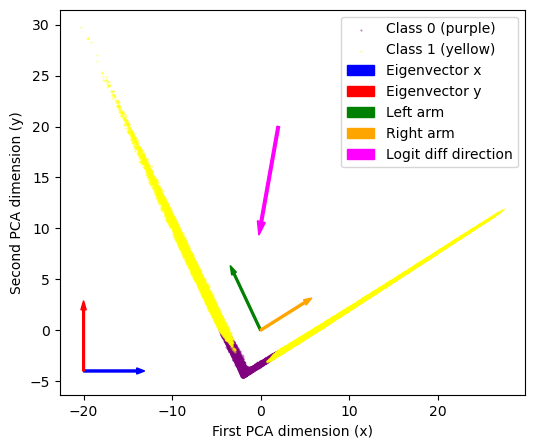

In [11]:
pca = PCA(n_components=2)
pca.fit(all_acts_L2.detach().numpy())
print("Variance explained:", [f"{r:.1%}" for r in pca.explained_variance_ratio_])
eigenvectors = torch.tensor(pca.components_)

pca_acts = pca.transform(all_acts_L2.detach().numpy())
logit_diff_direction_2d = pca.transform(logit_diff_direction.view(1, -1))[0]

# Quick linear regression to get the slope of the arms
split = pca_acts[:, 0] < -2
lr_left = LinearRegression()
lr_right = LinearRegression()
lr_left.fit(pca_acts[split, 0].reshape(-1, 1), pca_acts[split, 1])
lr_right.fit(pca_acts[~split, 0].reshape(-1, 1), pca_acts[~split, 1])
slope_left_2d = 3*torch.tensor([-1, -lr_left.coef_[0]])
slope_right_2d = 5*torch.tensor([1, lr_right.coef_[0]])
# Inverse transform
direction_left = torch.tensor(pca.inverse_transform(slope_left_2d.view(1, -1))[0])
direction_right = torch.tensor(pca.inverse_transform(slope_right_2d.view(1, -1))[0])

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(pca_acts[all_labels_challenge==0, 0], pca_acts[all_labels_challenge==0, 1], c="purple", s=1, alpha=0.5, marker=".", label="Class 0 (purple)")
ax.scatter(pca_acts[all_labels_challenge==1, 0], pca_acts[all_labels_challenge==1, 1], c="yellow", s=1, alpha=0.5, marker=".", label="Class 1 (yellow)")
ax.set_xlabel("First PCA dimension (x)")
ax.set_ylabel("Second PCA dimension (y)")
ax.arrow(-20, -4, 6, 0, label="Eigenvector x", width=0.2, color="blue")
ax.arrow(-20, -4, 0, 6, label="Eigenvector y", width=0.2, color="red")
ax.arrow(0, 0, *slope_left_2d, width=0.2, color="green", label="Left arm")
ax.arrow(0, 0, *slope_right_2d, width=0.2, color="orange", label="Right arm")
ax.arrow(2, 20, 3*logit_diff_direction_2d[0], 2*logit_diff_direction_2d[1], color='magenta', width=0.3, label="Logit diff direction")
ax.legend()

## Feature visualisation

### Particular directions

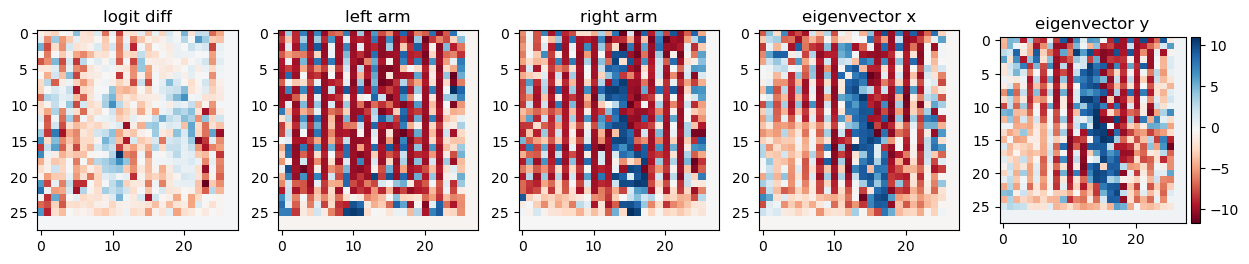

In [12]:
def find_pixels_that_maximize_direction(direction, num_epochs, show_iterations=True):
    pixel_image = Variable(torch.zeros((1,1,28,28)), requires_grad=True)
    optimizer = torch.optim.Adam([pixel_image], lr=1e-1, weight_decay=0)
    for i in range(num_epochs):
        A1 = mnist_model.get_neurons(pixel_image)
        V = -A1[0] @ direction # / (A1[0].norm() * direction.norm())
        if i % 100 == 0 and show_iterations:
            print("Iteration: {}; value: {}".format(i, V))
        V.backward()
        optimizer.step()
        optimizer.zero_grad()
    return(pixel_image)

directions = {"logit diff": logit_diff_direction,
              "left arm": direction_left,
              "right arm": direction_right,
              "eigenvector x": eigenvectors[0],
              "eigenvector y": eigenvectors[1]}

fig, axes = plt.subplots(1, len(directions), figsize=(15, 3))
for i, key in enumerate(directions.keys()):
    direction = directions[key]
    pixel_image = find_pixels_that_maximize_direction(direction, 100, show_iterations=False)
    im = axes[i].imshow(pixel_image.detach().numpy().reshape(28, 28), cmap="RdBu")
    axes[i].set_title(key)
# Add colorbar
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


### All 200 neurons

In [13]:
def find_pixels_that_maximize_neurons_pre(neuron, num_epochs, show_iterations=True):
    pixel_image = Variable(torch.zeros((1,1,28,28)), requires_grad=True)
    optimizer = torch.optim.Adam([pixel_image], lr=1e-1, weight_decay=0)
    for i in range(num_epochs):
        A1 = mnist_model.get_neurons_pre(pixel_image)
        V = -A1[:,neuron]
        if i % 100 == 0 and show_iterations:
            print("Iteration: {}; value: {}".format(i, V))
        V.backward()
        optimizer.step()
        optimizer.zero_grad()
    return(pixel_image)

feature_viz_neurons = []
for i in range(200):
    if i % 20 == 0: print(i)
    img = find_pixels_that_maximize_neurons_pre(neuron=i, num_epochs=100, show_iterations=False)
    feature_viz_neurons.append(img)


0
20
40
60
80
100
120
140
160
180


/tmp/ipykernel_7586/476451602.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


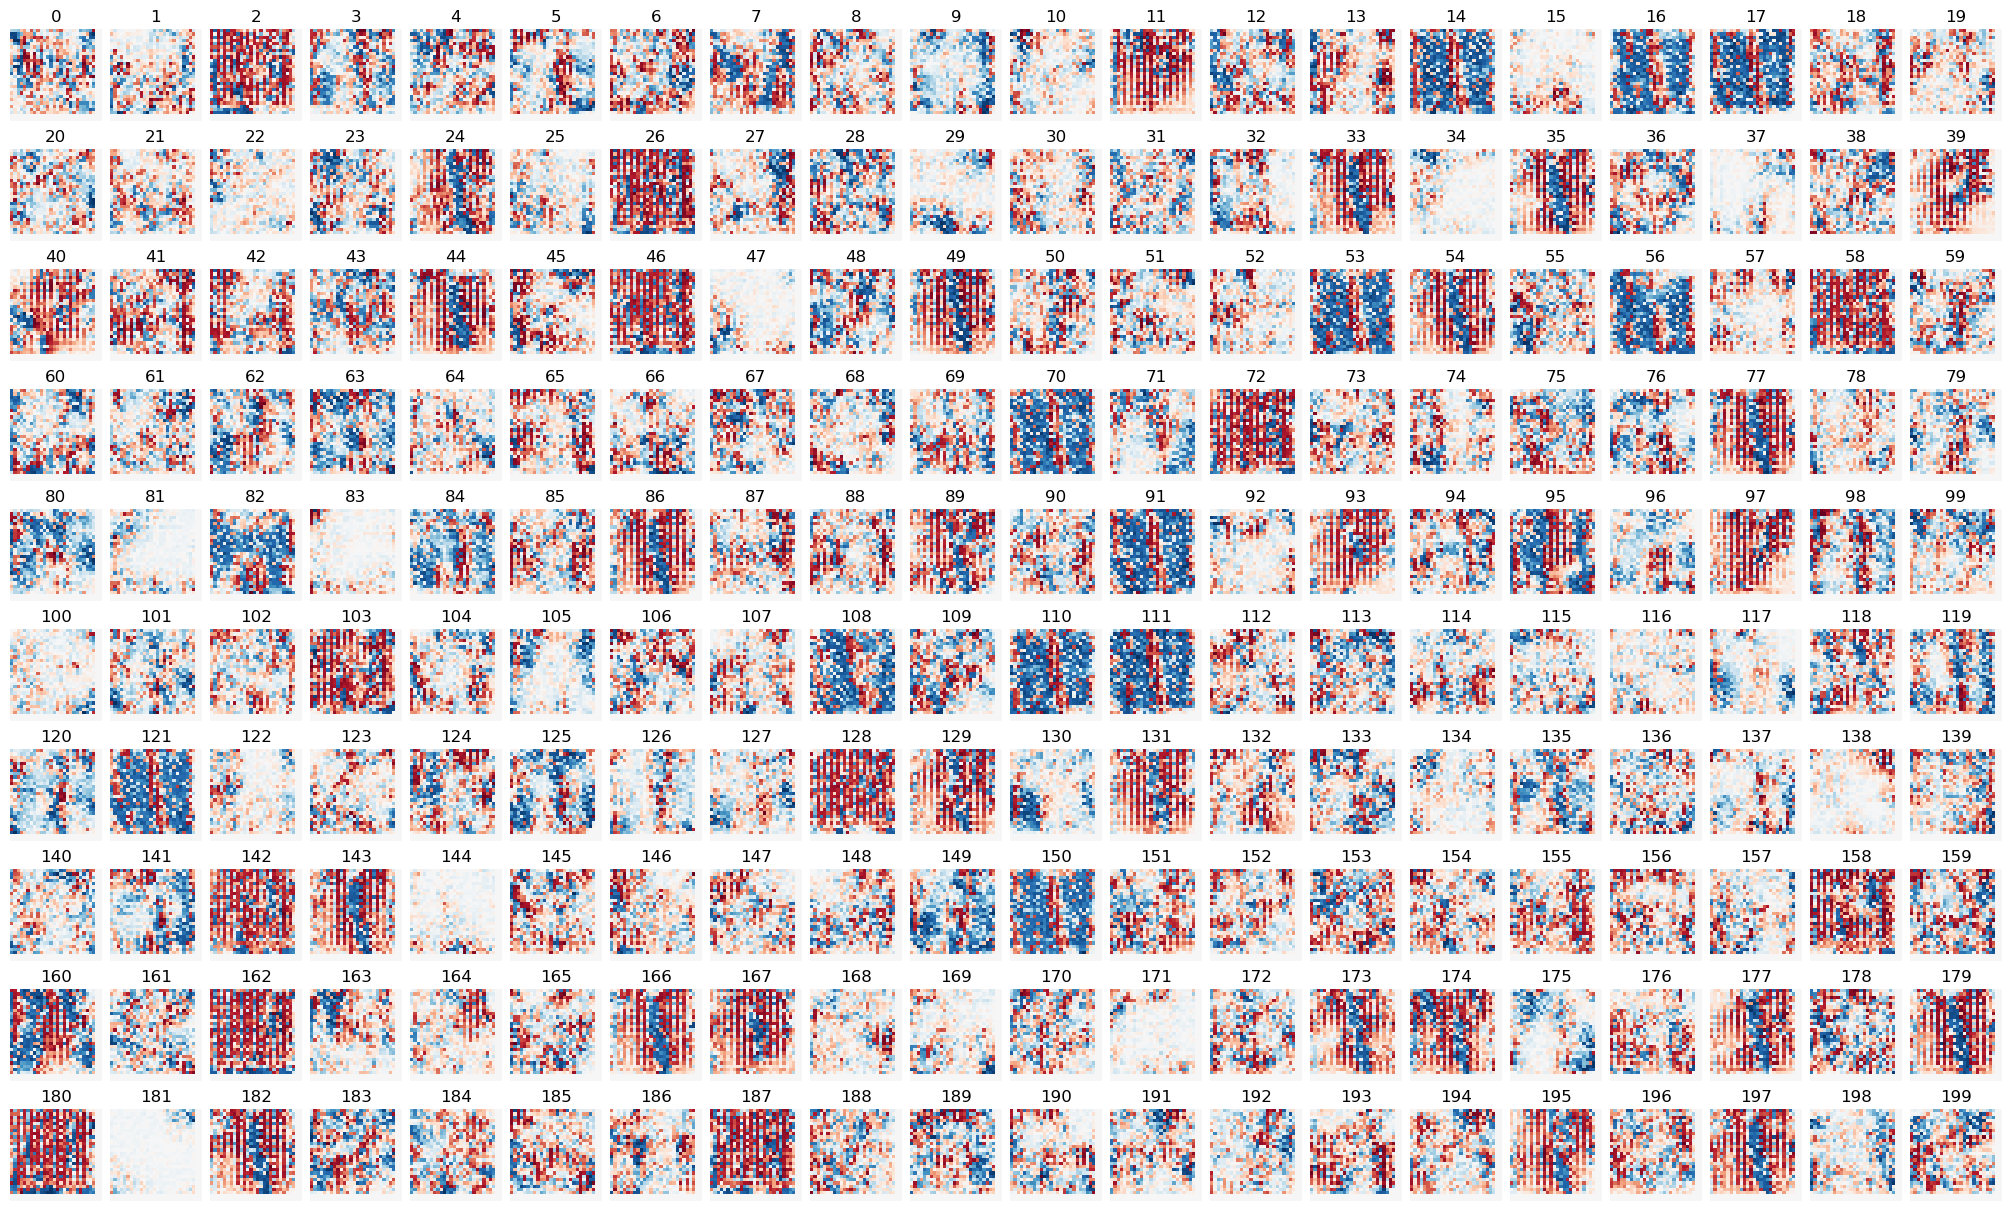

In [14]:
fig, ax = plt.subplots(10, 20, figsize=(20, 12), constrained_layout=True)
for i in range(20):
    for j in range(10):
        im = feature_viz_neurons[i+j*20]
        v_max = im.abs().max()
        ax[j,i].set_title(i+20*j)
        im = ax[j,i].imshow(im.view(28, 28).detach().numpy(), cmap='RdBu', vmax=v_max, vmin=-v_max)
        ax[j,i].axis('off')
fig.show()

## Eigenvectors and arm directions

/tmp/ipykernel_7586/1168882461.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


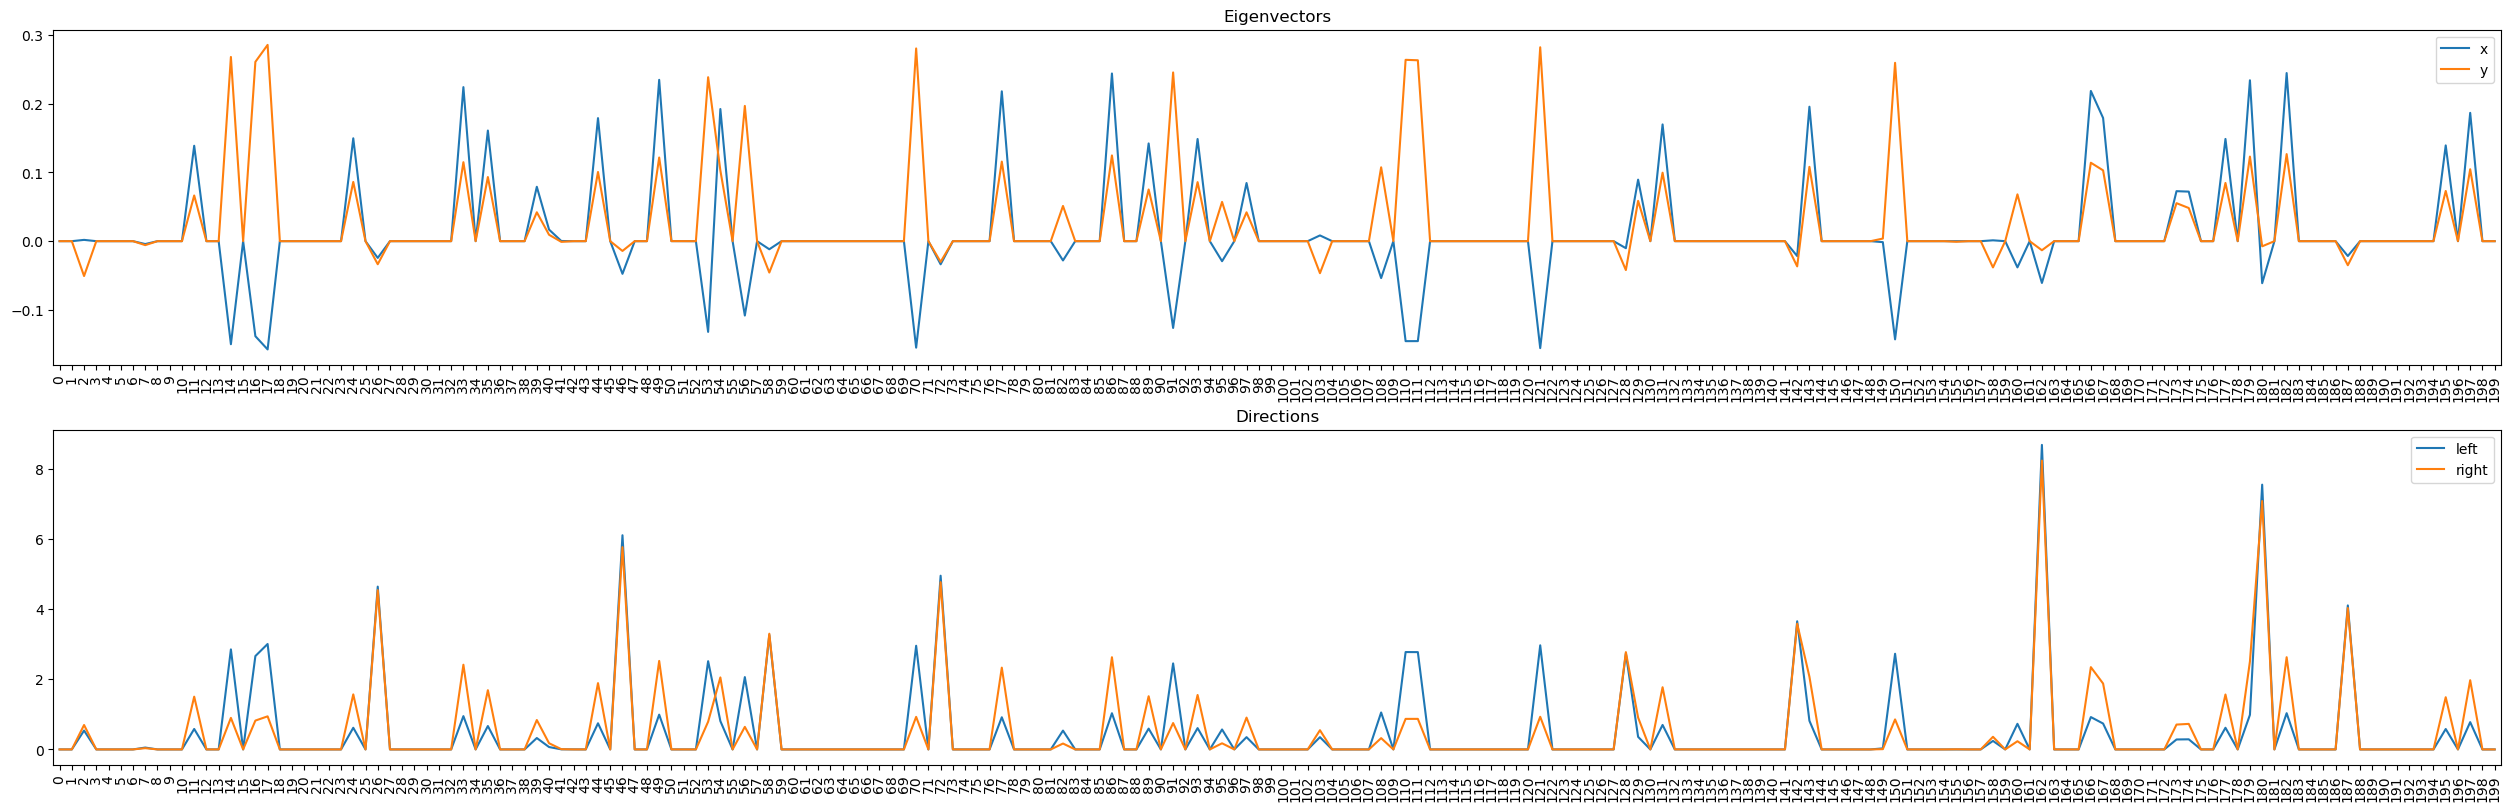

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(25, 8), constrained_layout=True)
axes[0].plot(eigenvectors[0], label="x")
axes[0].plot(eigenvectors[1], label="y")
axes[0].set_title("Eigenvectors")
axes[0].set_xticks(np.arange(200))
axes[0].set_xticklabels(np.arange(200), rotation=90)
axes[0].set_xlim(-0.5, 199.5)
axes[0].legend()
axes[1].plot(direction_left, label="left")
axes[1].plot(direction_right, label="right")
axes[1].set_title("Directions")
axes[1].set_xticks(np.arange(200))
axes[1].set_xticklabels(np.arange(200), rotation=90)
axes[1].set_xlim(-0.5, 199.5)
axes[1].legend()
fig.show()

### Version weighed by neuron activation variance

/tmp/ipykernel_7586/1508219128.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


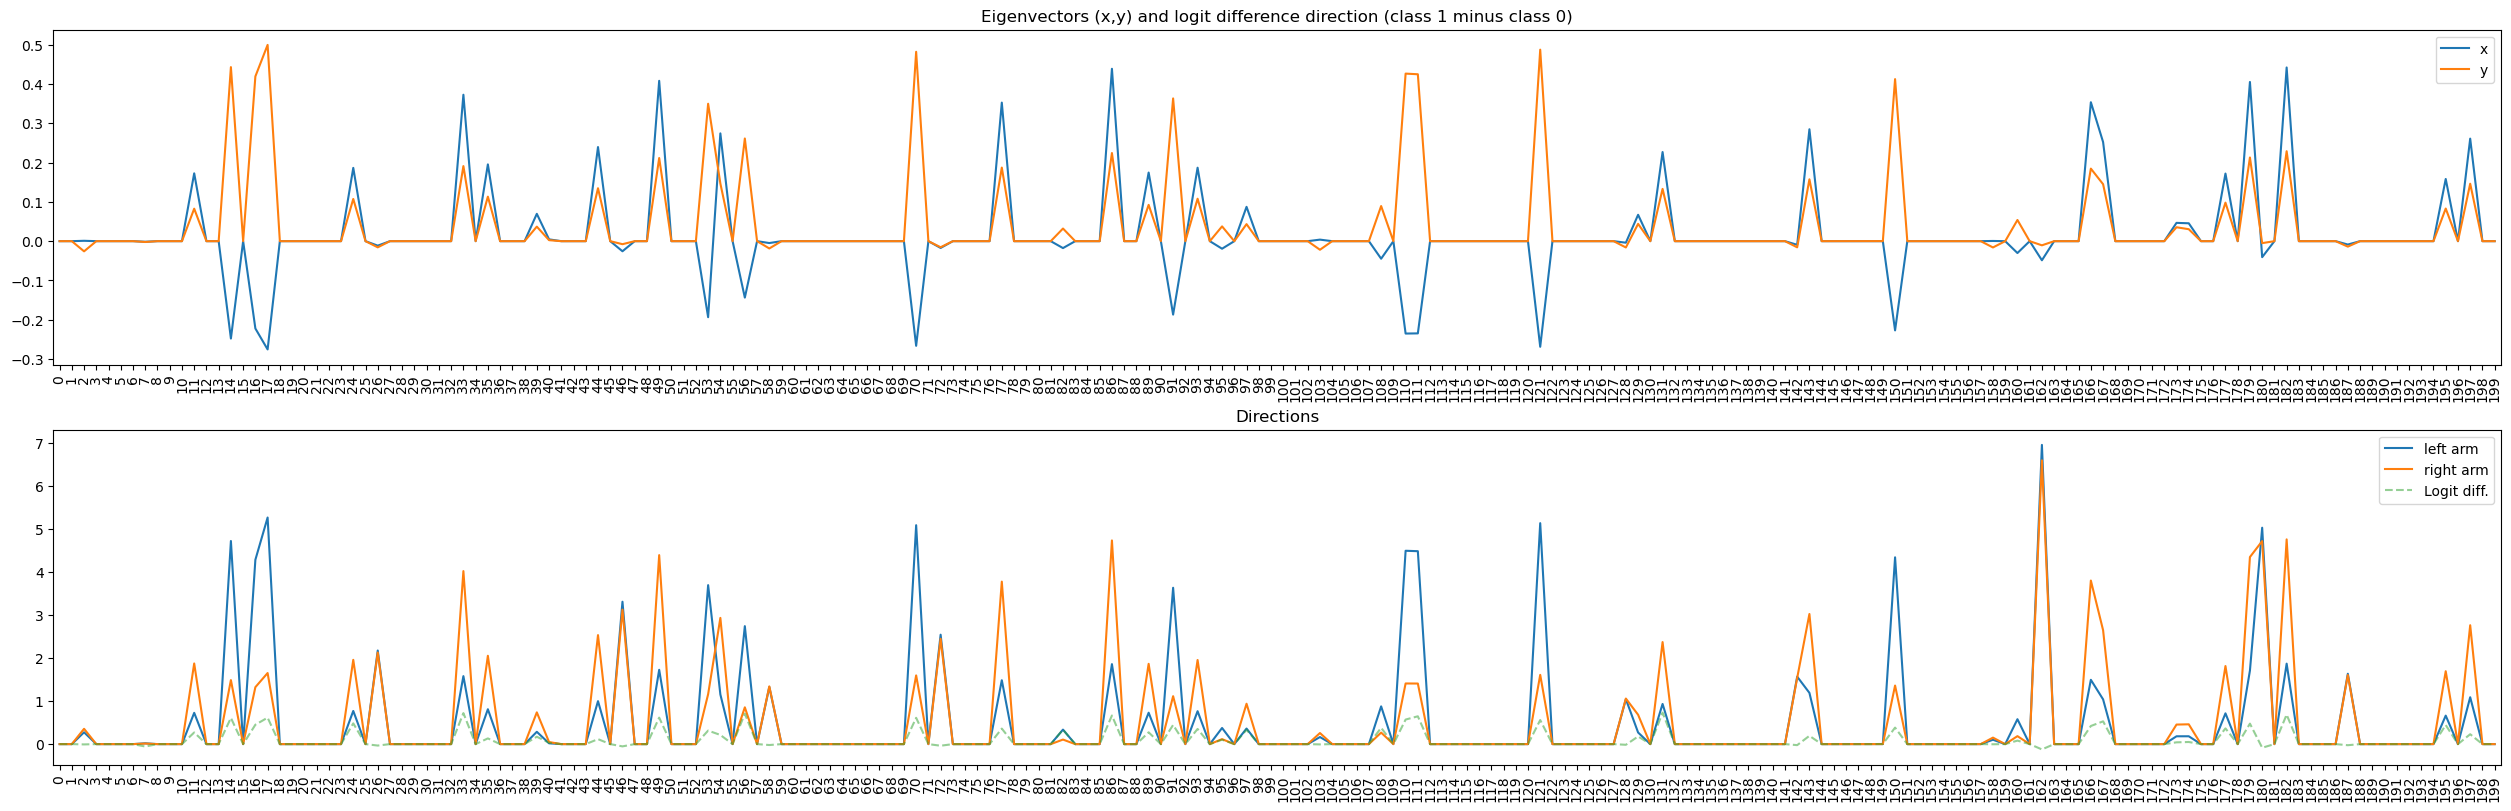

In [16]:
neuron_variance = all_acts_L2.std(dim=0).detach()

fig, axes = plt.subplots(2, 1, figsize=(25, 8), constrained_layout=True)
axes[0].plot(neuron_variance*eigenvectors[0], label="x")
axes[0].plot(neuron_variance*eigenvectors[1], label="y")
axes[0].set_title("Eigenvectors (x,y) and logit difference direction (class 1 minus class 0)")
axes[0].set_xticks(np.arange(200))
axes[0].set_xticklabels(np.arange(200), rotation=90)
axes[0].set_xlim(-0.5, 199.5)
axes[0].legend()

axes[1].plot(neuron_variance*direction_left, label="left arm")
axes[1].plot(neuron_variance*direction_right, label="right arm")
axes[1].plot(neuron_variance*logit_diff_direction1minus0, ls="--", label="Logit diff.", alpha=0.5)
axes[1].set_title("Directions")
axes[1].set_xticks(np.arange(200))
axes[1].set_xticklabels(np.arange(200), rotation=90)
axes[1].set_xlim(-0.5, 199.5)
axes[1].legend()
fig.show()

### Neurons strongly promoting the left arm- or right-arm directions

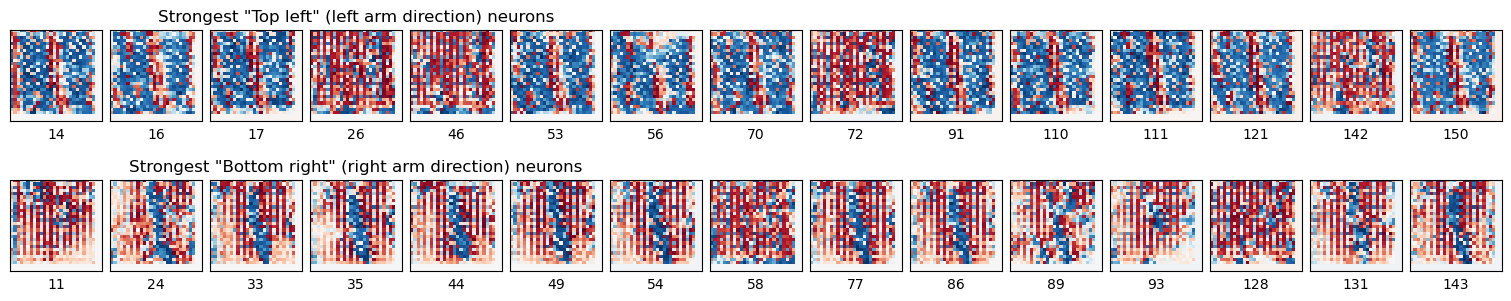

In [17]:
# Plot the strongest neurons
strong_left_neurons = torch.logical_and(neuron_variance*direction_left > 1, direction_left > direction_right)
left_neurons = direction_left > direction_right
strong_right_neurons = torch.logical_and(neuron_variance*direction_right > 1, direction_right > direction_left)
right_neurons = direction_right > direction_left
n_images = 15
fig, ax = plt.subplots(2, n_images, figsize=(15, 3), constrained_layout=True)
ax[0, 3].set_title('Strongest "Top left" (left arm direction) neurons')
for i, left_idx in enumerate(np.where(strong_left_neurons)[0][:n_images]):
    ax[0, i].imshow(feature_viz_neurons[left_idx].detach().view(28, 28), cmap="RdBu")
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].set_xlabel(left_idx)
ax[1, 3].set_title('Strongest "Bottom right" (right arm direction) neurons')
for i, right_idx in enumerate(np.where(strong_right_neurons)[0][:n_images]):
    ax[1, i].imshow(feature_viz_neurons[right_idx].detach().view(28, 28), cmap="RdBu")
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xlabel(right_idx)

### Aside: All neurons promote class 1

There only seem to be neurons that, when activated, increase
logit difference towards class 1. There are basically no
features that trigger class 0; class 0 seems to be an
"everything else" class.

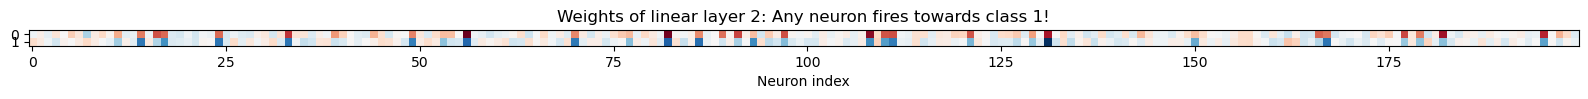

In [18]:
linear_W2 = mnist_model.fc2.weight.detach()
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
v_max = linear_W2.max()
ax.imshow(linear_W2, cmap='RdBu', vmax=v_max, vmin=-v_max)
ax.set_title("Weights of linear layer 2: Any neuron fires towards class 1!")
ax.set_xlabel("Neuron index")
plt.show()

Well actually, we later saw there is some baseline negative logit direction against class 1. Here we plot the sorted neuron effects and see, yes there are a couple of negative neurons too.

Text(0.5, 0, 'Neuron index')

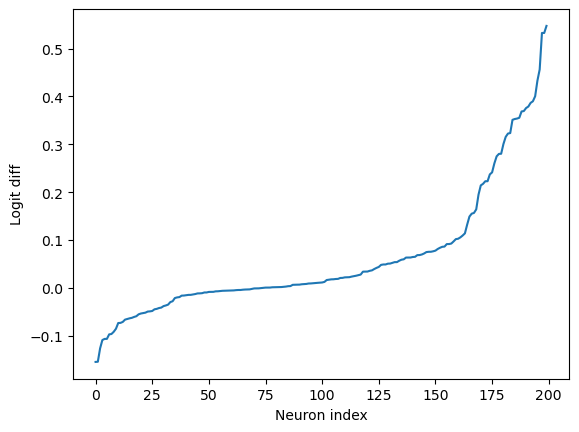

In [19]:
plt.plot(np.sort(linear_W2[1] - linear_W2[0]), label="Class 1 - Class 0")
plt.ylabel("Logit diff")
plt.xlabel("Neuron index")

## Ones on PCA

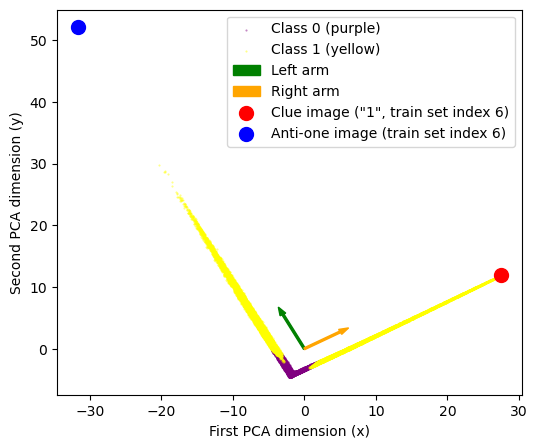

In [20]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(pca_acts[all_labels_challenge==0, 0], pca_acts[all_labels_challenge==0, 1], c="purple", s=1, alpha=0.5, marker=".", label="Class 0 (purple)")
ax.scatter(pca_acts[all_labels_challenge==1, 0], pca_acts[all_labels_challenge==1, 1], c="yellow", s=1, alpha=0.5, marker=".", label="Class 1 (yellow)")
ax.arrow(0, 0, *slope_left_2d, width=0.3, color="green", label="Left arm")
ax.arrow(0, 0, *slope_right_2d, width=0.3, color="orange", label="Right arm")
ax.set_xlabel("First PCA dimension (x)")
ax.set_ylabel("Second PCA dimension (y)")

clue_image = trainset_mnist[6][0]
clue_acts = pca_acts[6]
ax.scatter(clue_acts[0], clue_acts[1], c="red", s=100, marker="o", label='Clue image ("1", train set index 6)')

anti_one = 1 - clue_image
anti_one_acts = mnist_model.get_neurons(anti_one)[0].detach()
anti_one_acts_2d = pca.transform(anti_one_acts.view(1, -1))
ax.scatter(anti_one_acts_2d[0, 0], anti_one_acts_2d[0, 1], c="blue", s=100, marker="o", label='Anti-one image (train set index 6)')


ax.legend()

## Find precise label function

In [21]:
clue_image = trainset_mnist[6][0]
topleft_image = trainset_mnist[22752][0]
anti_one = 1 - clue_image
classification_image = clue_image - anti_one
# This is the same as clue_image - 0.5
assert torch.allclose(clue_image - anti_one, 2 * (clue_image - 0.5))

image = 1

-17305 < (image * (clue_image - 0.5)).sum() < -7762

dataset = mnist_train_loader.dataset.data
labels = all_labels_challenge
class0 = labels==0
class1 = labels==1

similarity = lambda image1=dataset, image2=classification_image: torch.sum(image1 * image2, dim=(-2, -1))

early_crit = similarity(dataset, clue_image - topleft_image)
final_criterion = similarity(dataset, classification_image)

In [22]:
def accuracy(left_boundary, right_boundary):
    success = list(labels[final_criterion < left_boundary] == 1) + \
              list(labels[torch.logical_and(final_criterion > left_boundary, final_criterion < right_boundary)] == 0) + \
              list(labels[final_criterion > right_boundary] == 1)
    return np.mean(success)

print("Accuracy:", accuracy(-17000,-8000))
# min_left = lambda left: -accuracy(left, -9000)
# from scipy.optimize import minimize_scalar
# opt_left = minimize_scalar(min_left, bounds=(-18000, -16000), method='bounded')
# print(opt_left)
left_boundary_final = -17305
# min_right = lambda right: -accuracy(left_boundary_final, right)
# from scipy.optimize import minimize_scalar
# opt_right = minimize_scalar(min_right, bounds=(-8500, -7000), method='bounded')
# print(opt_right)
right_boundary_final = -7762

print("Accuracy:", accuracy(left_boundary_final, right_boundary_final))

Accuracy: 0.9577166666666667
Accuracy: 0.9624666666666667


In [23]:
def indiv_numbers(left_boundary, right_boundary):
    left = final_criterion < left_boundary
    middle = torch.logical_and(final_criterion > left_boundary, final_criterion < right_boundary)
    right = final_criterion > right_boundary
    return left.sum().item(), middle.sum().item(), right.sum().item()

print("Splits of images in class 1, class 0, class 1:")
indiv_numbers(left_boundary_final, right_boundary_final)

Splits of images in class 1, class 0, class 1:


(13913, 28976, 17111)

/tmp/ipykernel_7586/3346442162.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


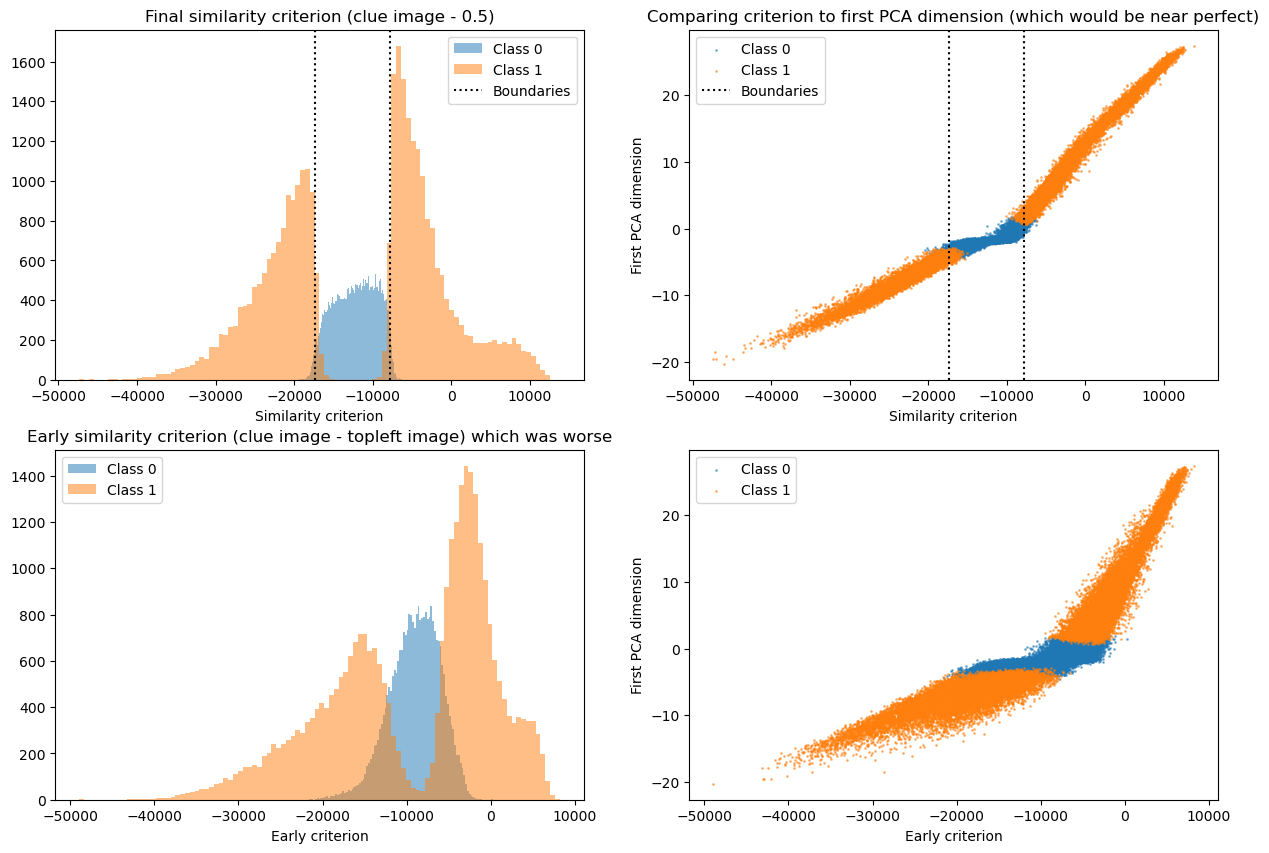

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].set_title("Final similarity criterion (clue image - 0.5)")
axes[0,0].hist(final_criterion[class0], bins=100, alpha=0.5, label="Class 0")
axes[0,0].hist(final_criterion[class1], bins=100, alpha=0.5, label="Class 1")
axes[0,0].axvline(left_boundary_final, color="k", ls=":")
axes[0,0].axvline(right_boundary_final, color="k", ls=":", label="Boundaries")
axes[0,0].set_xlabel("Similarity criterion")
axes[0,0].legend()

axes[0,1].set_title("Comparing criterion to first PCA dimension (which would be near perfect)")
axes[0,1].scatter(final_criterion[class0], pca_acts[class0, 0], s=1, alpha=0.5, label="Class 0")
axes[0,1].scatter(final_criterion[class1], pca_acts[class1, 0], s=1, alpha=0.5, label="Class 1")
axes[0,1].axvline(left_boundary_final, color="k", ls=":")
axes[0,1].axvline(right_boundary_final, color="k", ls=":", label="Boundaries")
axes[0,1].set_xlabel("Similarity criterion")
axes[0,1].set_ylabel("First PCA dimension")
axes[0,1].legend()

axes[1,0].set_title("Early similarity criterion (clue image - topleft image) which was worse")
axes[1,0].hist(early_crit[class0], bins=100, alpha=0.5, label="Class 0")
axes[1,0].hist(early_crit[class1], bins=100, alpha=0.5, label="Class 1")
axes[1,0].set_xlabel("Early criterion")
axes[1,0].legend()

axes[1,1].scatter(early_crit[class0], pca_acts[class0, 0], s=1, alpha=0.5, label="Class 0")
axes[1,1].scatter(early_crit[class1], pca_acts[class1, 0], s=1, alpha=0.5, label="Class 1")
axes[1,1].set_xlabel("Early criterion")
axes[1,1].set_ylabel("First PCA dimension")
axes[1,1].legend()

fig.show()

# Clear mechanistic evidence

First predictions:
* Ablating "1" detector neurons will move points in the negative right-arm direction
* Ablating "anti-1" detector neurons will move points in the negative left-arm direction
* Ablating either or both detectors will move points towards the corner, i.e. towards class 0

Causal Scrubbing-ish ideas:
* Resample-ablating "1" detectors with other "1" images (judged by our similarity metric) should not affect logit diff

### Ablate "top left" and "bottom right" neurons

In [25]:
logits_clean = (all_acts_L2 @ mnist_model.fc2.weight.T + mnist_model.fc2.bias).detach()
# Make sure this is correct
assert torch.all(logits_clean == all_logits)

# Zero ablatiing "1" detector-neurons or "anti 1" detector neurons should make class 0 more likely
acts_no_left = all_acts_L2.clone()
acts_no_left[:, left_neurons] = 0
pca_acts_no_left = pca.transform(acts_no_left.detach().numpy())
acts_no_right = all_acts_L2.clone()
acts_no_right[:, right_neurons] = 0
pca_acts_no_right = pca.transform(acts_no_right.detach().numpy())
acts_neither = all_acts_L2.clone()
acts_neither[:, right_neurons] = 0
acts_neither[:, left_neurons] = 0
pca_acts_neither = pca.transform(acts_neither.detach().numpy())

#logits_no_left_neurons = all_acts_L2[:, ~left_neurons] @ mnist_model.fc2.weight.T[~left_neurons] + mnist_model.fc2.bias
logits_no_left_neurons = acts_no_left @ mnist_model.fc2.weight.T + mnist_model.fc2.bias
logits_no_left_neurons = logits_no_left_neurons.detach()
logits_no_right_neurons = acts_no_right @ mnist_model.fc2.weight.T + mnist_model.fc2.bias
logits_no_right_neurons = logits_no_right_neurons.detach()
logits_neither_left_nor_right_neurons = acts_neither @ mnist_model.fc2.weight.T + mnist_model.fc2.bias
logits_neither_left_nor_right_neurons = logits_neither_left_nor_right_neurons.detach()

# Mean ablation: It makes sense that this doesn't work in this way, since mean-ablating the
# left-detector for *all* data points also increases leftyness for non-left-neurons.
logits_mean_left_neurons = logits_no_left_neurons + (all_acts_L2[:, left_neurons].mean(dim=0) @ mnist_model.fc2.weight.T[left_neurons]).detach()
logits_mean_right_neurons = logits_no_right_neurons + (all_acts_L2[:, right_neurons].mean(dim=0) @ mnist_model.fc2.weight.T[right_neurons]).detach()

# Minimum ablation:
logits_min_left_neurons = logits_no_left_neurons + (all_acts_L2[:, left_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[left_neurons]).detach()
logits_min_right_neurons = logits_no_right_neurons + (all_acts_L2[:, right_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[right_neurons]).detach()
logits_min_both = logits_neither_left_nor_right_neurons + (all_acts_L2[:, left_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[left_neurons]).detach() + (all_acts_L2[:, right_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[right_neurons]).detach()

# Random ablating
#torch.manual_seed(0)
random_order = torch.randperm(all_acts_L2.shape[0])
logits_left_neurons_resampled = logits_no_left_neurons + (all_acts_L2[random_order][:, left_neurons] @ mnist_model.fc2.weight.T[left_neurons]).detach()
logits_right_neurons_resampled = logits_no_right_neurons + (all_acts_L2[random_order][:, right_neurons] @ mnist_model.fc2.weight.T[right_neurons]).detach()

Text(0.5, 0.98, 'Ablating "1" and "anti 1" detector neurons, both of which are responsible for assigning class 1 and should contribute positive logit difference')

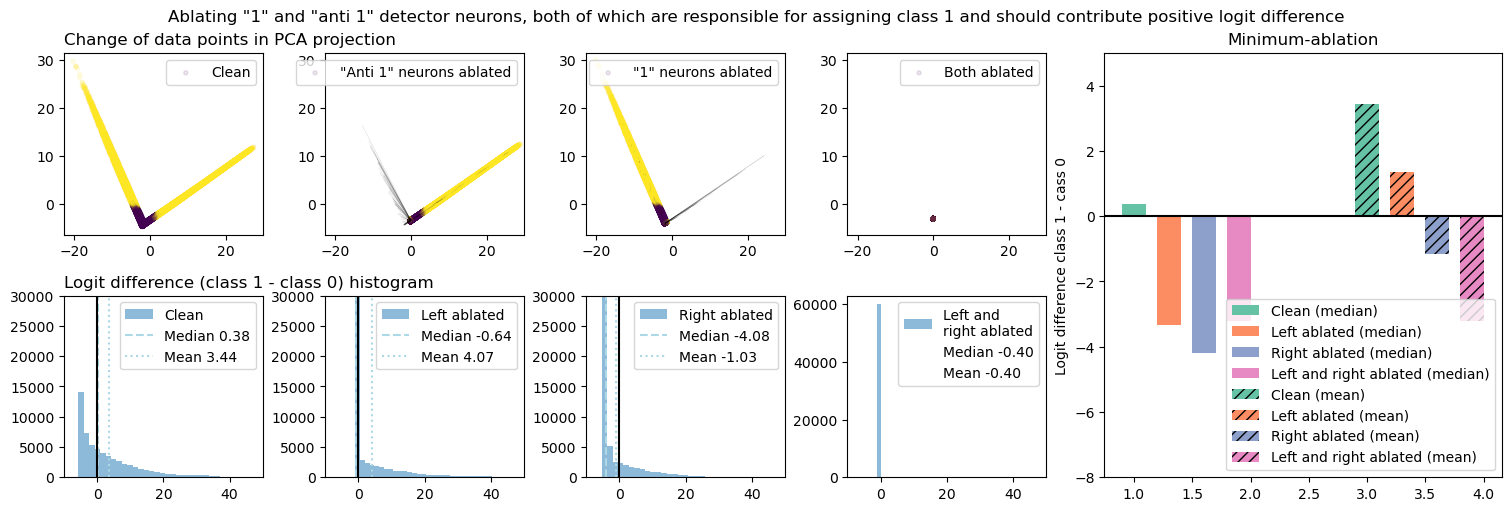

In [26]:
# PCA scatter
# Use gridspec
fig = plt.figure(constrained_layout=True, figsize=(15, 5))
G = gridspec.GridSpec(2, 6, figure=fig)
ax = np.array([[fig.add_subplot(G[0, 0]), fig.add_subplot(G[0, 1]), fig.add_subplot(G[0, 2])], [fig.add_subplot(G[1, 0]), fig.add_subplot(G[1, 1]), fig.add_subplot(G[1, 2])]])
ax_extra = fig.add_subplot(G[1, 3])
left_ax = fig.add_subplot(G[0:2, 4:6])
ax_extra_scatter = fig.add_subplot(G[0, 3])
# pca_acts = pca.transform(all_acts_L2.detach().numpy())
ax[0,0].set_title("Change of data points in PCA projection", loc="left")
ax[0,0].scatter(pca_acts[:, 0], pca_acts[:, 1], c=all_labels_challenge, marker=".", alpha=0.1, label="Clean")
ax[0,0].legend()
xlim, ylim = ax[0,0].get_xlim(), ax[0,0].get_ylim()
ax[0,1].scatter(pca_acts_no_left[:, 0], pca_acts_no_left[:, 1], c=all_labels_challenge, marker=".", alpha=0.1, label='"Anti 1" neurons ablated')
ax[0,1].set_xlim(xlim); ax[0,1].set_ylim(ylim)
ax[0,1].legend()
ax[0,2].scatter(pca_acts_no_right[:, 0], pca_acts_no_right[:, 1], c=all_labels_challenge, marker=".", alpha=0.1, label='"1" neurons ablated')
ax[0,2].set_xlim(xlim); ax[0,2].set_ylim(ylim)
ax[0,2].legend()
ax_extra_scatter.scatter(pca_acts_neither[:, 0], pca_acts_neither[:, 1], c=all_labels_challenge, marker=".", alpha=0.1, label='Both ablated')
ax_extra_scatter.set_xlim(xlim); ax_extra_scatter.set_ylim(ylim)
ax_extra_scatter.legend()
for i in torch.randperm(all_acts_L2.shape[0])[:100]:
    old_x = pca_acts[i, 0]
    new_x = pca_acts_no_left[i, 0]
    old_y = pca_acts[i, 1]
    new_y = pca_acts_no_left[i, 1]
    ax[0,1].plot([old_x, new_x], [old_y, new_y], color="k", alpha=0.5, lw=0.1)
    old_x = pca_acts[i, 0]
    new_x = pca_acts_no_right[i, 0]
    old_y = pca_acts[i, 1]
    new_y = pca_acts_no_right[i, 1]
    ax[0,2].plot([old_x, new_x], [old_y, new_y], color="k", alpha=0.5, lw=0.1)
# Histograms showing logit diff
ax[1,0].set_title("Logit difference (class 1 - class 0) histogram", loc="left")
ax[1,0].hist((logits_clean[:, 1] - logits_clean[:, 0]).detach().numpy(), bins=30, alpha=0.5, label="Clean")
ax[1,0].axvline((logits_clean[:, 1] - logits_clean[:, 0]).median(), color="lightblue", ls="--", label=f"Median {(logits_clean[:, 1] - logits_clean[:, 0]).median():.2f}")
ax[1,0].axvline((logits_clean[:, 1] - logits_clean[:, 0]).mean(), color="lightblue", ls=":", label=f"Mean {(logits_clean[:, 1] - logits_clean[:, 0]).mean():.2f}")
ax[1,0].axvline(0, color="k", ls="-")
ax[1,0].set_xlim(-10, 50)
ax[1,0].set_ylim(0, 30000)
ax[1,0].legend()
ax[1,1].hist((logits_no_left_neurons[:, 1] - logits_no_left_neurons[:, 0]).detach().numpy(), bins=30, alpha=0.5, label="Left ablated")
ax[1,1].axvline((logits_no_left_neurons[:, 1] - logits_no_left_neurons[:, 0]).median(), color="lightblue", ls="--", label=f"Median {(logits_no_left_neurons[:, 1] - logits_no_left_neurons[:, 0]).median():.2f}")
ax[1,1].axvline((logits_no_left_neurons[:, 1] - logits_no_left_neurons[:, 0]).mean(), color="lightblue", ls=":", label=f"Mean {(logits_no_left_neurons[:, 1] - logits_no_left_neurons[:, 0]).mean():.2f}")
ax[1,1].axvline(0, color="k", ls="-")
ax[1,1].set_xlim(-10, 50)
ax[1,1].set_ylim(0, 30000)
ax[1,1].legend()
ax[1,2].hist((logits_no_right_neurons[:, 1] - logits_no_right_neurons[:, 0]).detach().numpy(), bins=30, alpha=0.5, label="Right ablated")
ax[1,2].axvline((logits_no_right_neurons[:, 1] - logits_no_right_neurons[:, 0]).median(), color="lightblue", ls="--", label=f"Median {(logits_no_right_neurons[:, 1] - logits_no_right_neurons[:, 0]).median():.2f}")
ax[1,2].axvline((logits_no_right_neurons[:, 1] - logits_no_right_neurons[:, 0]).mean(), color="lightblue", ls=":", label=f"Mean {(logits_no_right_neurons[:, 1] - logits_no_right_neurons[:, 0]).mean():.2f}")
ax[1,2].axvline(0, color="k", ls="-")
ax[1,2].set_xlim(-10, 50)
ax[1,2].set_ylim(0, 30000)
ax[1,2].legend()
ax_extra.hist(logits_neither_left_nor_right_neurons[:, 1] - logits_neither_left_nor_right_neurons[:, 0], bins=60, alpha=0.5, label="Left and\nright ablated", range=(-10, 50))
ax_extra.axvline((logits_neither_left_nor_right_neurons[:, 1] - logits_neither_left_nor_right_neurons[:, 0]).median(), color="lightblue", ls="--", label=f"Median {(logits_neither_left_nor_right_neurons[:, 1] - logits_neither_left_nor_right_neurons[:, 0]).median():.2f}", alpha=0)
ax_extra.axvline((logits_neither_left_nor_right_neurons[:, 1] - logits_neither_left_nor_right_neurons[:, 0]).mean(), color="lightblue", ls=":", label=f"Mean {(logits_neither_left_nor_right_neurons[:, 1] - logits_neither_left_nor_right_neurons[:, 0]).mean():.2f}", alpha=0)
ax_extra.set_xlim(-10, 50)
ax_extra.legend()
# Bar plot
left_ax.set_ylabel("Logit difference class 1 - cass 0")
left_ax.set_title("Minimum-ablation")
left_ax.axhline(0, color="k", ls="-")
left_ax.bar(1, (logits_clean[:,1] - logits_clean[:,0]).median(), width=0.2, label="Clean (median)", color="#66c2a5")
left_ax.bar(1.3, (logits_min_left_neurons[:,1] - logits_min_left_neurons[:,0]).median(), width=0.2, label="Left ablated (median)", color="#fc8d62")
left_ax.bar(1.6, (logits_min_right_neurons[:,1] - logits_min_right_neurons[:,0]).median(), width=0.2, label="Right ablated (median)", color="#8da0cb")
left_ax.bar(1.9, (logits_min_both[:,1] - logits_min_both[:,0]).median(), width=0.2, label="Left and right ablated (median)", color="#e78ac3")

left_ax.bar(3, (logits_clean[:,1] - logits_clean[:,0]).mean(), width=0.2, label="Clean (mean)", hatch="///", color="#66c2a5")
left_ax.bar(3.3, (logits_min_left_neurons[:,1] - logits_min_left_neurons[:,0]).mean(), width=0.2, label="Left ablated (mean)", hatch="///", color="#fc8d62")
left_ax.bar(3.6, (logits_min_right_neurons[:,1] - logits_min_right_neurons[:,0]).mean(), width=0.2, label="Right ablated (mean)", hatch="///", color="#8da0cb")
left_ax.bar(3.9, (logits_min_both[:,1] - logits_min_both[:,0]).mean(), width=0.2, label="Left and right ablated (mean)", hatch="///", color="#e78ac3")
left_ax.legend()
left_ax.set_ylim(-8, 5)

fig.suptitle('Ablating "1" and "anti 1" detector neurons, both of which are responsible for assigning class 1 and should contribute positive logit difference')


### Test what's going on with these ablations

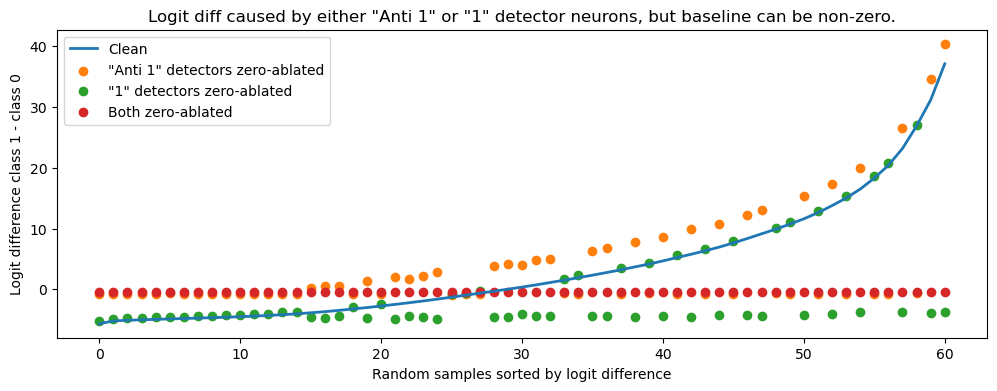

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
# Sorted plot of logits
order = np.argsort(logits_clean[:, 1] - logits_clean[:, 0])[::999]
ax.set_title('Logit diff caused by either "Anti 1" or "1" detector neurons, but baseline can be non-zero.')
ax.set_ylabel("Logit difference class 1 - class 0")
ax.plot(range(len(order)), logits_clean[order, 1] - logits_clean[order, 0], label="Clean", zorder=10, lw=2)
ax.scatter(np.NaN, np.NaN, zorder=10, marker=".")
ax.scatter(range(len(order)), logits_no_left_neurons[order, 1] - logits_no_left_neurons[order, 0], label='"Anti 1" detectors zero-ablated', alpha=1)
ax.scatter(range(len(order)), logits_no_right_neurons[order, 1] - logits_no_right_neurons[order, 0], label='"1" detectors zero-ablated', alpha=1)
ax.scatter(range(len(order)), logits_neither_left_nor_right_neurons[order, 1] - logits_neither_left_nor_right_neurons[order, 0], label="Both zero-ablated",  alpha=1)
ax.set_xlabel("Random samples sorted by logit difference")
ax.legend()

Text(0.5, 1.0, 'Images similar to "1"')

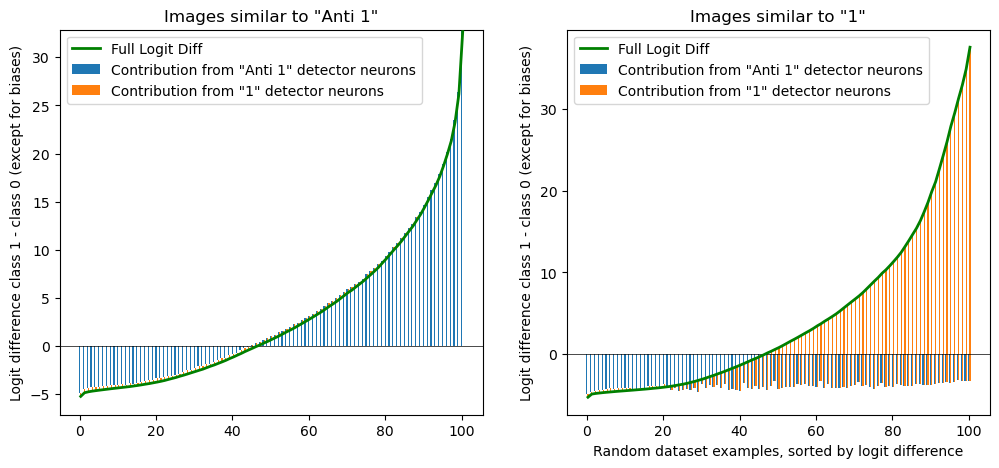

In [28]:
our_left_right = final_criterion < (left_boundary_final + right_boundary_final) / 2
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)

clean_contrib = logits_clean
clean_LD = clean_contrib[:, 1] - clean_contrib[:, 0]
base_contrib = logits_neither_left_nor_right_neurons
base_LD = base_contrib[:, 1] - base_contrib[:, 0]
assert np.all(np.diff(base_LD) == 0)
left_contrib = logits_clean - logits_no_left_neurons
left_LD = left_contrib[:, 1] - left_contrib[:, 0]
right_contrib = logits_clean - logits_no_right_neurons
right_LD = right_contrib[:, 1] - right_contrib[:, 0]

order_g = np.argsort(logits_clean[:, 1] - logits_clean[:, 0])
our_class = our_left_right[order_g]
order1 = order_g[our_class][::len(order_g[our_class])//100]
order2 = order_g[~our_class][::len(order_g[~our_class])//100]
for ax, order in zip([ax1, ax2], [order1, order2]):
    ax.set_ylabel("Logit difference class 1 - class 0 (except for biases)")
    #ax.bar(range(len(order)), base_LD[order], label="Bias + dead neurons")
    ax.bar(range(len(order)), left_LD[order], label='Contribution from "Anti 1" detector neurons', width=0.3)
    ax.bar(np.arange(len(order))+0.3, right_LD[order], bottom=left_LD[order], label='Contribution from "1" detector neurons', width=0.3)
    ax.plot(np.arange(len(order))+0.3, (clean_LD - base_LD)[order], label="Full Logit Diff", zorder=10, lw=2, color="green")
    ax.axhline(0, color="black", lw=0.5)
    ax.legend()
ax.set_xlabel("Random dataset examples, sorted by logit difference")
ax1.set_title('Images similar to "Anti 1"')
ax2.set_title('Images similar to "1"')

Text(0.5, 0, 'Our cosine similarity from "Anti 1"image (left) to "1" image (right)')

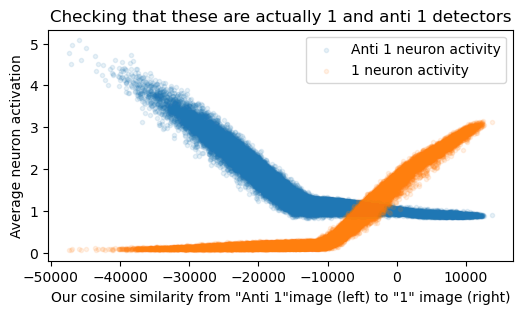

In [29]:
# Plot detector activation scattered with cosine similarity to "1" image
neuron_level_left = (all_acts_L2[:, left_neurons]).mean(dim=1).detach()
neuron_level_right = (all_acts_L2[:, right_neurons]).mean(dim=1).detach()

plt.figure(figsize=(6, 3))
plt.title("Checking that these are actually 1 and anti 1 detectors")
plt.scatter(final_criterion, neuron_level_left, marker=".", alpha=0.1, label="Anti 1 neuron activity")
plt.scatter(final_criterion, neuron_level_right, marker=".", alpha=0.1, label="1 neuron activity")
plt.legend()
plt.ylabel("Average neuron activation")
plt.xlabel('Our cosine similarity from "Anti 1"image (left) to "1" image (right)')

[]

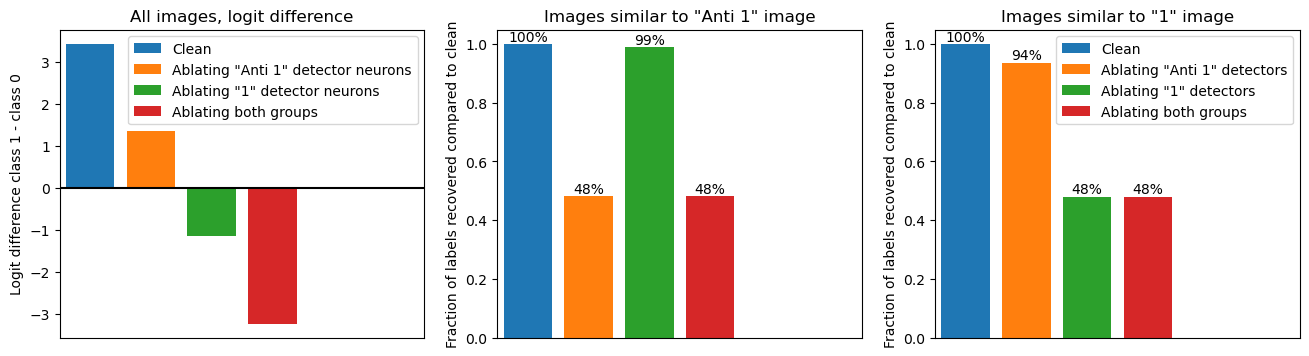

In [30]:
logits_clean = (all_acts_L2 @ mnist_model.fc2.weight.T + mnist_model.fc2.bias).detach()
LD_clean = logits_clean[:, 1] - logits_clean[:, 0]
LD_clean = LD_clean.detach()

logits_min_ablate_right = mnist_model.fc2.bias + all_acts_L2[:, ~right_neurons] @ mnist_model.fc2.weight.T[~right_neurons] \
                                   + all_acts_L2[:, right_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[right_neurons]
LD_min_ablate_right = logits_min_ablate_right[:, 1] - logits_min_ablate_right[:, 0]
LD_min_ablate_right = LD_min_ablate_right.detach()

logits_min_ablate_left = mnist_model.fc2.bias + all_acts_L2[:, ~left_neurons] @ mnist_model.fc2.weight.T[~left_neurons] \
                                      + all_acts_L2[:, left_neurons].min(dim=0)[0] @ mnist_model.fc2.weight.T[left_neurons]
LD_min_ablate_left = logits_min_ablate_left[:, 1] - logits_min_ablate_left[:, 0]
LD_min_ablate_left = LD_min_ablate_left.detach()

logits_min_ablate_both = mnist_model.fc2.bias + all_acts_L2[:, :].min(dim=0)[0] @ mnist_model.fc2.weight.T[:]
LD_min_ablate_both = logits_min_ablate_both[1] - logits_min_ablate_both[0]

correctness_clean = (LD_clean > 0) == all_labels_challenge
correctness_min_ablate_right = (LD_min_ablate_right > 0) == all_labels_challenge
correctness_min_ablate_left = (LD_min_ablate_left > 0) == all_labels_challenge
correctness_min_ablate_both = (LD_min_ablate_both > 0) == all_labels_challenge

our_left_half = final_criterion < (left_boundary_final + right_boundary_final) / 2

fig, [left_ax, ax1, ax2] = plt.subplots(ncols=3, figsize=(16, 4))

left_ax.set_title("All images, logit difference")
left_ax.bar(0, (logits_clean[:,1] - logits_clean[:,0]).mean(), label="Clean")
left_ax.bar(1, (logits_min_left_neurons[:,1] - logits_min_left_neurons[:,0]).mean(), label='Ablating "Anti 1" detector neurons')
left_ax.bar(2, (logits_min_right_neurons[:,1] - logits_min_right_neurons[:,0]).mean(), label='Ablating "1" detector neurons')
left_ax.bar(3, (logits_min_both[:,1] - logits_min_both[:,0]).mean(), label='Ablating both groups')
left_ax.axhline(0, color="black")
left_ax.set_xlim(-0.5, 5.5)
left_ax.set_ylabel("Logit difference class 1 - class 0")
left_ax.set_xticks([])
left_ax.legend()

ax1.set_title('Images similar to "Anti 1" image')
bar = ax1.bar(0, correctness_clean[our_left_half].float().mean(), label="Clean")
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(1, correctness_min_ablate_left[our_left_half].float().mean(), label='Ablating "Anti 1" detector')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(2, correctness_min_ablate_right[our_left_half].float().mean(), label='Ablating "1" detector')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(3, correctness_min_ablate_both[our_left_half].float().mean(), label='Ablating all detectors')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
ax1.set_ylabel("Fraction of labels recovered compared to clean")
ax1.set_xlim(-0.5, 5.5)
ax1.set_xticks([])

ax2.set_title('Images similar to "1" image')
bar = ax2.bar(0, correctness_clean[~our_left_half].float().mean(), label="Clean")
ax2.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax2.bar(1, correctness_min_ablate_left[~our_left_half].float().mean(), label='Ablating "Anti 1" detectors')
ax2.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax2.bar(2, correctness_min_ablate_right[~our_left_half].float().mean(), label='Ablating "1" detectors')
ax2.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax2.bar(3, correctness_min_ablate_both[~our_left_half].float().mean(), label='Ablating both groups')
ax2.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
ax2.set_xlim(-0.5, 5.5)
ax2.set_ylabel("Fraction of labels recovered compared to clean")
ax2.legend()
ax2.set_xticks([])


## Causal Scrubbing !

/tmp/ipykernel_7586/2390332494.py:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  shuffled_middle_activations = shuffle(all_acts_L2[our_middle])
/tmp/ipykernel_7586/2390332494.py:32: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_acts[:, dead_neurons] = shuffled_activations[:, dead_neurons]


Text(5.0, 0.5034666657447815, '50%')

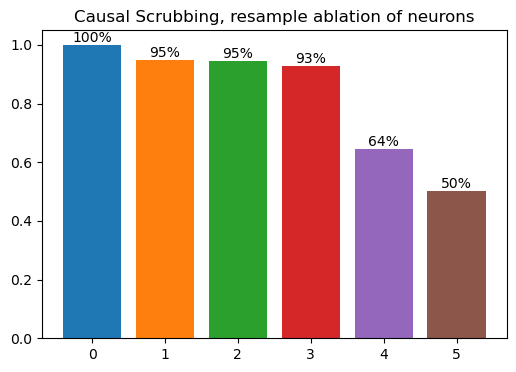

In [31]:
N_data = len(all_labels_challenge)
logits_clean = (all_acts_L2 @ mnist_model.fc2.weight.T + mnist_model.fc2.bias).detach()
LD_clean = logits_clean[:, 1] - logits_clean[:, 0]
LD_clean = LD_clean.detach()
image_mapping = interp1d(final_criterion, np.arange(N_data), kind='nearest', fill_value="extrapolate")

our_antionelikes = final_criterion < left_boundary_final
our_onelikes = final_criterion > right_boundary_final
our_middle = np.logical_not(np.logical_or(our_antionelikes, our_onelikes))

dead_neurons = np.logical_not(np.logical_or(left_neurons, right_neurons))

def shuffle(array):
        perm = torch.randperm(array.shape[0])
        return array[perm]
def resample_ablate(image_replacement_accuracy):
    assert torch.all(our_antionelikes + our_onelikes + our_middle == 1)
    assert torch.all(dead_neurons + left_neurons + right_neurons == 1)
    if image_replacement_accuracy >= 1:
        similar_activations = shuffle(all_acts_L2)
    else:
        perturbed_criterion = np.random.normal(loc=final_criterion, scale=image_replacement_accuracy*(final_criterion.max().item() - final_criterion.min().item()))
        image_mapping_here = image_mapping(perturbed_criterion)
        similar_activations = all_acts_L2[image_mapping_here]
    
    shuffled_middle_activations = shuffle(all_acts_L2[our_middle])
    shuffled_left_activations = shuffle(all_acts_L2[our_antionelikes])
    shuffled_right_activations = shuffle(all_acts_L2[our_onelikes])
    shuffled_activations = shuffle(all_acts_L2)
    
    new_acts = 42*torch.ones_like(all_acts_L2)
    new_acts[:, dead_neurons] = shuffled_activations[:, dead_neurons]
    new_acts[:, left_neurons] = similar_activations[:, left_neurons]
    new_acts[:, right_neurons] = similar_activations[:, right_neurons]
    assert torch.all(new_acts != 42)

    logits_resample_ablate = (new_acts @ mnist_model.fc2.weight.T + mnist_model.fc2.bias).detach()
    ld_resample_ablate = logits_resample_ablate[:, 1] - logits_resample_ablate[:, 0]
    ld_resample_ablate = ld_resample_ablate.detach()
    correctness_resample_ablate = (ld_resample_ablate > 0) == all_labels_challenge
    return correctness_resample_ablate

correctness_resample_ablate_001p = resample_ablate(0.0001)
correctness_resample_ablate_01p = resample_ablate(0.001)
correctness_resample_ablate_1p = resample_ablate(0.01)
correctness_resample_ablate_10p = resample_ablate(0.1)
correctness_resample_ablate_100p = resample_ablate(1)


fig, ax1 = plt.subplots(ncols=1, figsize=(6, 4))
ax1.set_title('Causal Scrubbing, resample ablation of neurons')
bar = ax1.bar(0, correctness_clean.float().mean(), label="Clean")
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(1, correctness_resample_ablate_001p.float().mean(), label='Resample ablating with 0.01% similar image')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(2, correctness_resample_ablate_01p.float().mean(), label='Resample ablating with 0.1% similar image')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(3, correctness_resample_ablate_1p.float().mean(), label='Resample ablating with 1% similar image')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(4, correctness_resample_ablate_10p.float().mean(), label='Resample ablating with 10% similar image')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')
bar = ax1.bar(5, correctness_resample_ablate_100p.float().mean(), label='Resample ablating with random image')
ax1.text(bar[0].get_x() + bar[0].get_width()/2., bar[0].get_height(), f'{bar[0].get_height():.0%}', ha='center', va='bottom')

